# Ensemble Learning

## Overview

In this short lab we will go into some "hands-on" aspects of ensemble learning, covering aspects of the bias-variance decomposition, random forests (bagged decision trees with random subspaces) and boosting algorithms discussed in lectures. The lab is in the form of a walk-though with questions you should try to answer for yourself before reading through the solutions. 

### Acknowledgement

*This notebook contains several excerpts from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas (one of the original sklearn developers); the original content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).* 

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

*The boosting example is modified from code from Chapter 13 of Machine Learning: An Algorithmic Perspective (2nd Edition) by Stephen Marsland (http://stephenmonika.net)*


## Introduction

As with previous labs, the objective is to expose some of the methods and to show some visualizations, since although some of the methods appear quite complex, many of the underlying ideas are quite straightforward. We will use the ``Seaborn`` visualization package which builds on and extends the capabilities of the standard ``Matplotlib`` package. *You will need to install these if you want to run this notebook locally.*

You will also need to ensure the file ```helpers_ensembles.py``` in the folder or directory you run this notebook from.

In [24]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

## Bias-Variance

Recall the usual setting: suppose we train a model on some data, then test on some data _not_ used for training, and we evaluate the observed test error as an estimate of the _generalization error_ of the model.

**Question:** how could *bias* be observed in the estimation of error for a learned model?

the difference between the true value and the data predicted by the learned model

**Question:** how could *variance* be observed in the estimation of error for a learned model?

the difference between the models which trained by different data set on a same distribution

Think of how you would answer these questions before proceeding.

To answer these questions we will attempt firstly to visualize learning outcomes where the effect of bias and variance on error are clearly evident.

### Bias-Variance Tradeoff

We'll start by using regression for this visualization, and compare linear to non-linear models.

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Next let's generate some data, and fit the models.

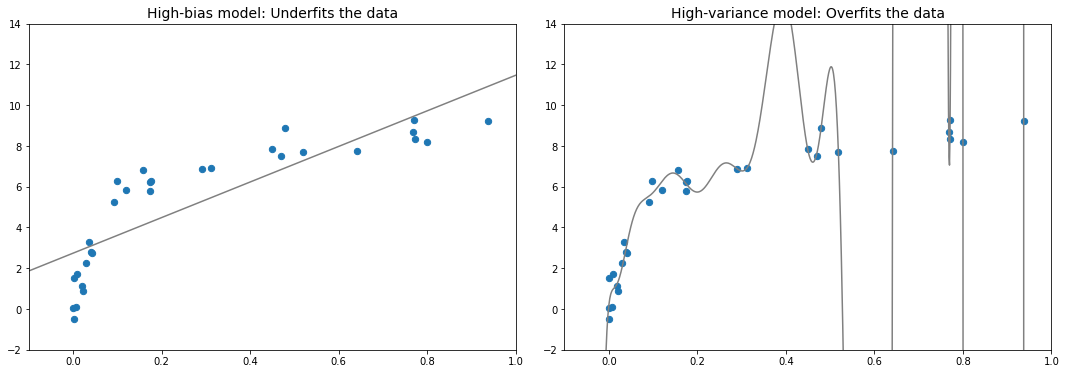

In [26]:
def make_data(N=30, err=0.8, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data()
xfit = np.linspace(-0.1, 1.0, 1000)[:, None]
model1 = PolynomialRegression(1).fit(X, y)
model20 = PolynomialRegression(20).fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].scatter(X.ravel(), y, s=40) #x.ravel like x.flatten
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)

ax[1].scatter(X.ravel(), y, s=40)
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14);

Looking at these plots can tell us something about the error. The first plot shows a linear model. Since the data appears to be non-linear, the error will have a considerable *bias* component, since the model can never fit all the data points. In the second plot the polynomial regression appears to have fit the data almost completely. However, the error of this model will have a considerable *variance* component due to the complexity of the fitted polynomial. 

#### Bias-Variance Tradeoff Metrics

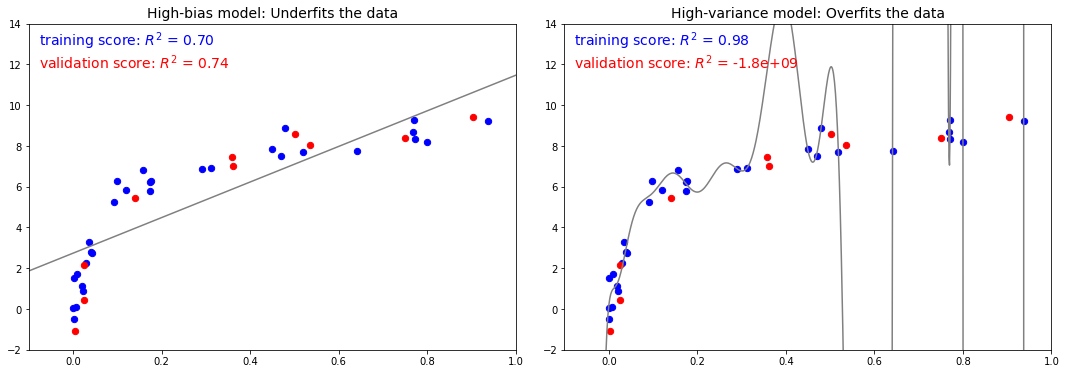

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

X2, y2 = make_data(10, rseed=42)

ax[0].scatter(X.ravel(), y, s=40, c='blue')
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)
ax[0].scatter(X2.ravel(), y2, s=40, c='red')
ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='blue')
ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X2, y2)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='red')

ax[1].scatter(X.ravel(), y, s=40, c='blue')
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)
ax[1].scatter(X2.ravel(), y2, s=40, c='red')
ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='blue')
ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X2, y2)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='red');

The $R^2$ metric (coefficient of determination) is an estimate of how well a model fits a dataset. 

For the linear regression model, goodness of fit is about the same on training set and validation set. This suggests variance of this model is not high. However, linear regression does not fit the training set as well as polynomial regression, suggesting bias of the linear model is too high. On the other hand, polynomial regression does not fit the validation set well, suggesting the variance of this model is too high.

#### Validation Curve

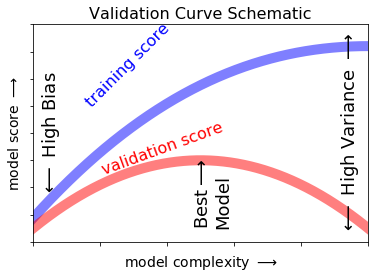

In [28]:
x = np.linspace(0, 1, 1000)
y1 = -(x - 0.5) ** 2
y2 = y1 - 0.33 + np.exp(x - 1)

fig, ax = plt.subplots()
ax.plot(x, y2, lw=10, alpha=0.5, color='blue')
ax.plot(x, y1, lw=10, alpha=0.5, color='red')

ax.text(0.15, 0.2, "training score", rotation=45, size=16, color='blue')
ax.text(0.2, -0.05, "validation score", rotation=20, size=16, color='red')

ax.text(0.02, 0.1, r'$\longleftarrow$ High Bias', size=18, rotation=90, va='center')
ax.text(0.98, 0.1, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.48, -0.12, 'Best$\\longrightarrow$\nModel', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.5)

ax.set_xlabel(r'model complexity $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Validation Curve Schematic", size=16);

This plot shows the trade-off of model complexity and model performance using a scoring metric for both training set and validation (off-training-set) data. The falling off in validation score reflects overfitting of the training set.

#### Learning Curve

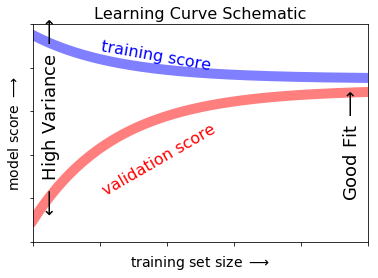

In [27]:
N = np.linspace(0, 1, 1000)
y1 = 0.75 + 0.2 * np.exp(-4 * N)
y2 = 0.7 - 0.6 * np.exp(-4 * N)

fig, ax = plt.subplots()
ax.plot(x, y1, lw=10, alpha=0.5, color='blue')
ax.plot(x, y2, lw=10, alpha=0.5, color='red')

ax.text(0.2, 0.88, "training score", rotation=-10, size=16, color='blue')
ax.text(0.2, 0.5, "validation score", rotation=30, size=16, color='red')

ax.text(0.98, 0.45, r'Good Fit $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.02, 0.57, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel(r'training set size $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Learning Curve Schematic", size=16);

This plot shows the effect of increasing the sample size of data used in learning – "big data" can enable complex models to be learned without overfitting the training set.

### Bias-Variance in Validation

We can now summarise what we have visualized as follows:

a <span style="color:red">high bias</span> learner will *tend to* <span style="color:red">under</span>fit

a <span style="color:red">high variance</span> learner will *tend to* <span style="color:red">over</span>fit

Although can only be a general guideline, it gives us at least a partial answer to the questions we asked above of how we can detect bias and variance when attempting to validate machine learning methods in terms of their error.



### Decision Tree Example

The bias-variance decomposition does not have the same mathematical derivation for classification as it does for regression with squared error. Nonetheless, we can still consider the role of a bias and a variance component in classification error.

Here is an instance space which contains randomly generated examples centred in 4 regions of the 2D area. Each region represents a different class.

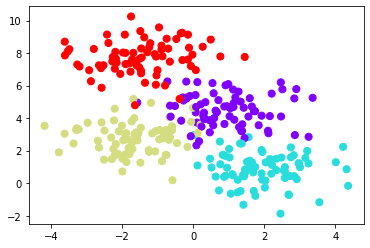

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
from helpers_ensembles import visualize_tree

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
# print(X)
# print(y)
# print(X[:, 0], X[:, 1])
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

### Decision Tree Levels

Here is an example of learning a decision tree at successive depths of refinement, where at each depth a further refinement of the tree is applied to the instance space. At each depth, the decision tree gives a finer partition of the instance space, resulting in a lower-error classification.

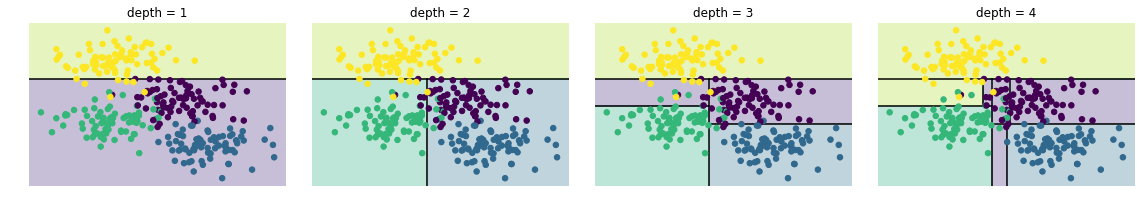

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

### Decision Tree Overfitting

**Question:** What kind of problem do you think decision tree is likely to have when the depth goes deeper?

One way to see the effect of this is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

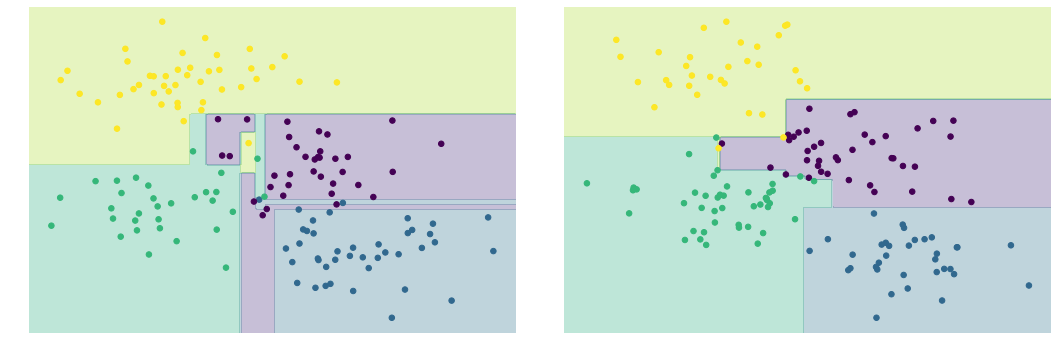

In [30]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1]);

**Question:** What do you think is going on in this visualization? What do you think can be done to improve this result?

## Ensembles of Estimators: Random Forests

**Question:** What could we do to make use of multiple overfitting estimators to reduce the effect of overfitting?

Let's write a quick utility function to help us visualize the output of a classifier:

In [43]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
                        clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

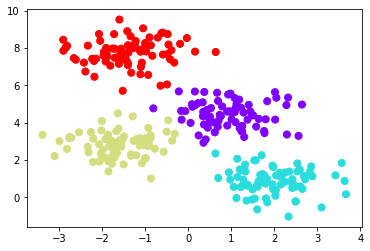

In [44]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,random_state=0, cluster_std=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

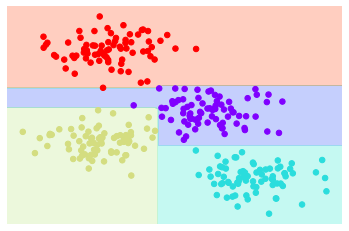

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

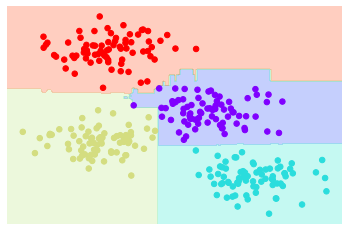

In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

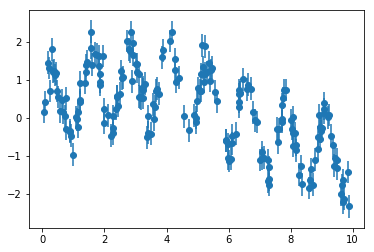

In [35]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

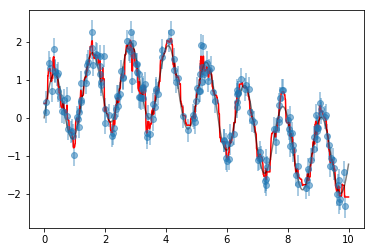

In [36]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classifying Digits

We previously looked at the hand-written digits data, and we use that again here to see how the random forest classifier can be used in this context.

In [37]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points:

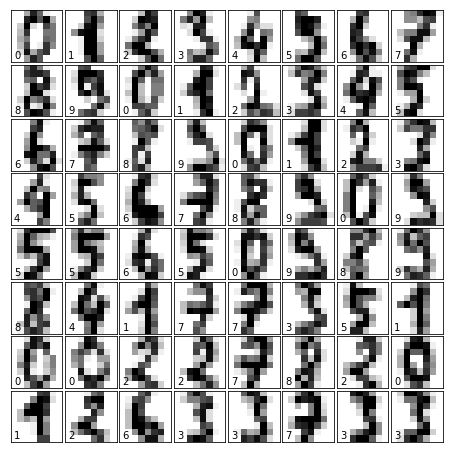

In [38]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a random forest as follows:

In [39]:
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:


In [40]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:


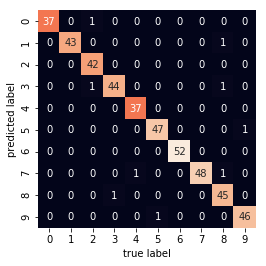

In [41]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a very accurate classification of the digits data.

### Summary of Random Forests

This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.

**Question:** What advantages does the random forests method have?

**Question:** What disadvantages does random forests method have?

## Boosting

**Question:** How does boosting work?

**Question:** What can we see after each time we run the boosting algorithm?

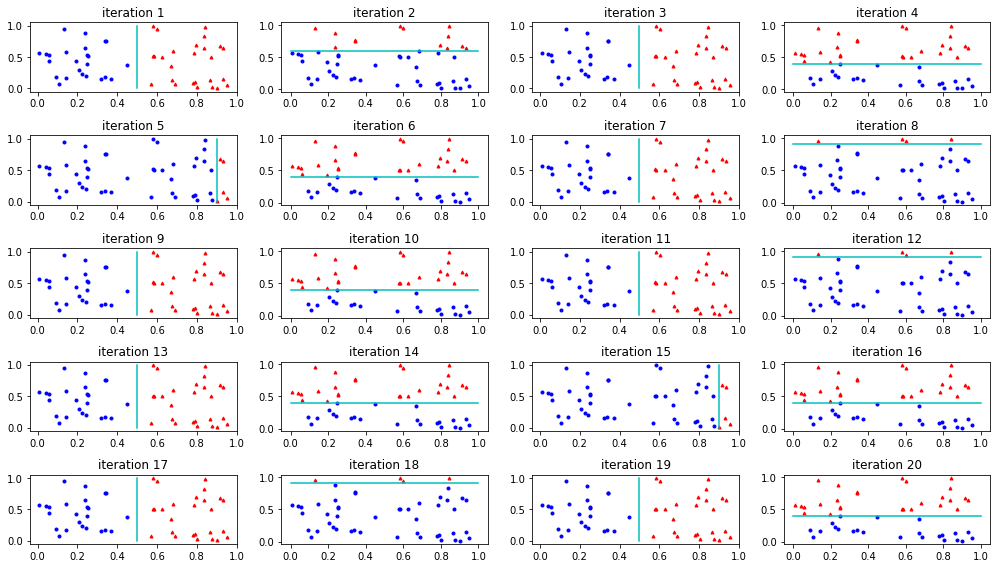

<Figure size 432x288 with 0 Axes>

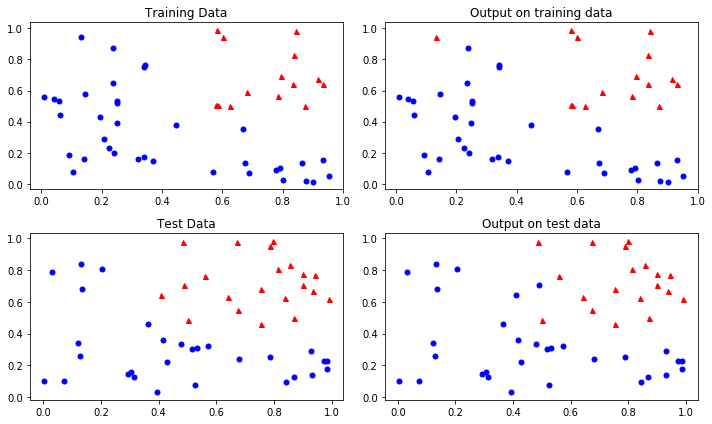

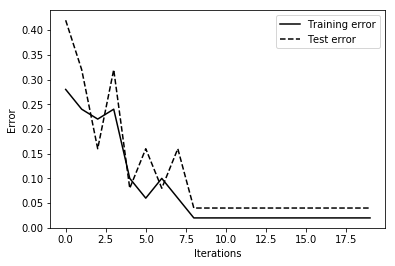

In [42]:
import matplotlib.pyplot as pl
import numpy as np

def train(data,classes,weights,whichdim):

    error = np.zeros(10)
    for value in range(0,10,1):
        val = float(value)/10                                ### try all values on current dimension in steps of 0.1
        classn = np.where(data[whichdim,:]<val,-1,1)         ### all data points below this line are -1
        ind = np.where(classes!=classn)                      ### all misclassified data points
        error[value] = np.sum(weights[ind])                  ### sum up weighted errors for line at this value
    return whichdim,float(np.argmin(error))/10,1-whichdim    ### return least error line

def classify(data,classes,dim,value):
    dim = int(dim)# modify here
    # modify here 
    classn = np.where(data[dim,:]<value,-1,1)
    ind = np.where(classes!=classn,1,0)
    return classn, ind

def boost(data,classes,testdata,testclasses):
    T = 20
    N = np.shape(data)[1]
    ndim = np.shape(data)[0]
    classifiers = np.zeros((2,T))         ### a 2 x 20 array; a classifier is learned on each of 20 boosting iterations
    whichdim = 0                          ### initial choice of x or y dimension for classifier

    w = np.ones((N,T+1),dtype=float)/N    ### initialise each of N examples to have uniform weight
    index = np.ones((N,T+1))              ### same shape, used for class of each example
    e = np.zeros(T)                       ### error store for each iteration
    alpha = np.zeros(T+1)                 ### for the classifier weight on each iteration

    err = np.zeros((2,T+1))               ### for classification error for each example on each iteration

    poutput = np.zeros((T+1,N))
    ptoutput = np.zeros((T+1,N))
    po = np.zeros(T+1)
    pto = np.zeros(T+1)
    f = pl.figure(figsize=(14,8))
    for t in range(T):
        classifiers[0,t],classifiers[1,t],whichdim = train(data,classes,w[:,t],whichdim)
        outputs,errors = classify(data,classes,classifiers[0,t],classifiers[1,t])
        toutputs,terrors = classify(testdata,testclasses,classifiers[0,t],classifiers[1,t])
        which = np.where(outputs<=0)
        which2 = np.where(outputs>0)
        
        ax=f.add_subplot(5,4,t+1)
        ax.plot(data[0,which],data[1,which],'bo',ms=3)
        ax.plot(data[0,which2],data[1,which2],'r^',ms=3)
        dummy1=np.linspace(0., 1., num=11)
        dummy0=np.zeros(11)
        dummy2=np.add(dummy0,classifiers[1,t])
        
        if  classifiers[0,t] == 0:
            ax.plot(dummy2,dummy1,'c-')
        else:
            ax.plot(dummy1,dummy2,'c-')
        cur_title = 'iteration ' + str(t+1)
        ax.set_title(cur_title)
        
        index[:,t] = errors
        e[t] = np.sum(w[:,t]*index[:,t])/np.sum(w[:,t])     ### total error of classifiers on this iteration

        if t>0 and (e[t]==0 or e[t]>=0.5):                  ### Halt: we no longer have a weak learner on iteration t
            T=t
            alpha = alpha[:t]
            index = index[:,:t]
            w = w[:,:t]
            break

        alpha[t] = np.log((1-e[t])/e[t])                   ### version in lectures prefaced by 1/2 to ease derivation
        w[:,t+1] = w[:,t]* np.exp(alpha[t]*index[:,t])     ### reweight all examples
        w[:,t+1] = w[:,t+1]/np.sum(w[:,t+1])               ### normalise to keep constant weight

        outputs = np.zeros((N,t))
        toutputs = np.zeros((N,t))
        for i in range(t):
            outputs[:,i],errors  = classify(data,classes,classifiers[0,i],classifiers[1,i])
            toutputs[:,i],terrors  = classify(testdata,testclasses,classifiers[0,i],classifiers[1,i])

        for n in range(N):
            poutput[t,n] = np.sum(alpha[:t]*outputs[n,:])/sum(alpha)
            ptoutput[t,n] = np.sum(alpha[:t]*toutputs[n,:])/sum(alpha)
        poutput[t,:] = np.where(poutput[t,:]>0,1,-1)
        ptoutput[t,:] = np.where(ptoutput[t,:]>0,1,-1)
        po[t] = np.shape(np.where(poutput[t,:]!=classes))[1]
        pto[t] = np.shape(np.where(ptoutput[t,:]!=testclasses))[1]
    pl.tight_layout()

    outputs = np.zeros((N,np.shape(w)[1]))
    for t in range(T):
        outputs[:,t],errors  = classify(data,classes,classifiers[0,t],classifiers[1,t])

    output = np.zeros(N)
    for n in range(N):
        output[n] = np.sum(alpha*outputs[n,:])/np.sum(alpha)
    pl.figure()
    f = pl.figure(figsize=(10,6))
    ax=f.add_subplot(2,2,1)
    classes = np.where(((data[0,:]>0.4) & (data[1,:]>0.4)),1,-1)             ### positive labels in top-right corner 
    which = np.where(classes==-1)
    which2 = np.where(classes==1)
    ax.plot(data[0,which],data[1,which],'bo',ms=5)
    ax.plot(data[0,which2],data[1,which2],'r^',ms=5)
    ax.set_title('Training Data')

    ax=f.add_subplot(2,2,2)
    which = np.where(output<=0)
    which2 = np.where(output>0)
    ax.plot(data[0,which],data[1,which],'bo',ms=5)
    ax.plot(data[0,which2],data[1,which2],'r^',ms=5)
    ax.set_title('Output on training data')

    outputs = np.zeros((N,np.shape(w)[1]))
    for t in range(T):
        outputs[:,t],errors  = classify(testdata,testclasses,classifiers[0,t],classifiers[1,t])

    output = np.zeros(N)
    for n in range(N):
        output[n] = np.sum(alpha*outputs[n,:])/np.sum(alpha)
    which = np.where(output<=0)
    which2 = np.where(output>0)
    ax=f.add_subplot(2,2,4)
    ax.set_title('Output on test data')
    ax.plot(testdata[0,which],testdata[1,which],'bo',ms=5)
    ax.plot(testdata[0,which2],testdata[1,which2],'r^',ms=5)

    ax=f.add_subplot(2,2,3)
    ax.set_title('Test Data')
    which = np.where(testclasses==-1)
    which2 = np.where(testclasses==1)
    ax.plot(testdata[0,which],testdata[1,which],'bo',ms=5)
    ax.plot(testdata[0,which2],testdata[1,which2],'r^',ms=5)
    pl.tight_layout()

    pl.figure()
    pl.plot(np.arange(T),po[:T]/N,'k-',np.arange(T),pto[:T]/N,'k--')
    pl.legend(('Training error','Test error'))
    pl.xlabel('Iterations')
    pl.ylabel('Error')
    return output

def test_boost():
    pl.ion()                               ### interactive plotting on
    ndata = 50
    data = np.random.rand(2,ndata)         ### uniformly distributed random 2D data
    classes = np.where(((data[0,:]>0.4) & (data[1,:]>0.4)),1,-1)             ### positive labels in top-right corner 
    testdata = np.random.rand(2,ndata)
    testclasses = np.where(((testdata[0,:]>0.4) & (testdata[1,:]>0.4)),1,-1) ### positive labels in top-right corner 
    boost(data,classes,testdata,testclasses)


test_boost()
plt.show()

#### Discussion of boosting output

In the plots above we can see ...